In [3]:
from datetime import date, datetime
from typing import Any, Dict, Iterator, List, Optional, Union

import pandas as pd
import pytz
from polygon import RESTClient
from polygon.rest.models import (
    Agg,
    DailyOpenCloseAgg,
    GroupedDailyAgg,
    PreviousCloseAgg,
    Sort,
)
from polygon.rest.models.request import RequestOptionBuilder
from urllib3 import HTTPResponse

import pandas as pd

import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

# Function to get the Polygon RESTClient
def get_client():
    return RESTClient("VoUAUxVML9mwSpopBIK7vPjIF_Y25Yk5")  # Replace with your actual API key

# Function to get stock data for a specific company within a time window
def get_stock_data(client, ticker, start_date, end_date):
    stock_data = list_aggs(
        client, ticker, 6, "hour", start_date, end_date, limit=500000
    )
    return stock_data

# TODO: Account for market holidays and half-days
# TODO: Determine timezone from stock/equity ticker
def within_trading_hours(
    timestamp: Union[str, int, datetime, date], timezone: str
) -> bool:
    """
    Determine whether a given instant is within trading hours for a particular exchange.

    :param timestamp: The timestamp (in milliseconds) to be checked.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: True if the timestamp is within trading hours, False otherwise.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    if dt.weekday() < 5:
        opening_time = dt.replace(hour=9, minute=30, second=0, microsecond=0)
        closing_time = dt.replace(hour=16, minute=0, second=0, microsecond=0)
        return opening_time <= dt <= closing_time
    else:
        return False


# TODO: Determine timezone from stock/equity ticker
def parse_timestamp(timestamp: Union[str, int, datetime, date], timezone: str) -> str:
    """
    Parse a timestamp to a readable format for easy comparisons.

    :param timestamp: The timestamp (in milliseconds) to be formatted.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: Date-time representation in the following format: %Y-%m-%d %H:%M:%S %Z.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    return dt.strftime("%Y-%m-%d %H:%M:%S %Z")


def agg_to_dict(agg: Agg):
    """
    Convert an aggregate object to a dictionary, and add any extra data that may be useful.

    :param agg: The aggregate object to parse.
    :return: Dictionary with keys corresponding to attributes of the object.
    """
    return {
        "open": agg.open,
        "high": agg.high,
        "low": agg.low,
        "close": agg.close,
        "volume": agg.volume,
        "vwap": agg.vwap,
        "timestamp": agg.timestamp,
        "datetime": parse_timestamp(agg.timestamp, "America/New_York"),
        "transactions": agg.transactions,
        "otc": agg.otc,
    }


def list_aggs(
    client: RESTClient,
    ticker: str,
    multiplier: int,
    timespan: str,
    # "from" is a keyword in python https://www.w3schools.com/python/python_ref_keywords.asp
    from_: Union[str, int, datetime, date],
    to: Union[str, int, datetime, date],
    include_extended_hours: bool = False,
    adjusted: Optional[bool] = None,
    sort: Optional[Union[str, Sort]] = None,
    limit: Optional[int] = None,
    params: Optional[Dict[str, Any]] = None,
    raw: bool = False,
    options: Optional[RequestOptionBuilder] = None,
) -> pd.DataFrame:
    """
    List aggregate bars for a ticker over a given date range in custom time window sizes.

    :param client: The RESTClient object to perform the request with.
    :param ticker: The ticker symbol.
    :param multiplier: The size of the timespan multiplier.
    :param timespan: The size of the time window.
    :param from_: The start of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param to: The end of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param include_extended_hours: True if pre-market and after-hours trading data are to be included, False otherwise.
    :param adjusted: Whether or not the results are adjusted for splits. By default, results are adjusted. Set this to false to get results that are NOT adjusted for splits.
    :param sort: Sort the results by timestamp. asc will return results in ascending order (oldest at the top), desc will return results in descending order (newest at the top).The end of the aggregate time window.
    :param limit: Limits the number of base aggregates queried to create the aggregate results. Max 50000 and Default 5000. Read more about how limit is used to calculate aggregate results in Polygon's on Aggregate Data API Improvements.
    :param params: Any additional query params.
    :param raw: Return raw object instead of results object.
    :return: Pandas DataFrame representation of aggregate objects.
    """
    aggs = []
    for a in client.list_aggs(
        ticker,
        multiplier,
        timespan,
        from_,
        to,
        adjusted=adjusted,
        sort=sort,
        limit=limit,
        params=params,
        raw=raw,
        options=options,
    ):
        if include_extended_hours or within_trading_hours(
            a.timestamp, "America/New_York"
        ):
            aggs.append(agg_to_dict(a))
    return pd.DataFrame(aggs)




import pandas as pd
import numpy as np
import yfinance as yf



# Function to calculate skewness-based states
def skewness_states(df, window):
    df['skewness'] = df['daily_returns'].rolling(window=window).skew()
    df['skewness_state'] = np.where(df['skewness'] > 0, 'Positive', 'Negative')
    return df

def volatility_states(df, window, k):
    # Calculate cumulative sum until sign change
    cur_sign = df["sign"].iloc[0]
    track = df['daily_returns'].iloc[0]
    cum_sum = [track]

    for i in range(1, len(df)):
        sign = df["sign"].iloc[i]
        if sign == cur_sign:
            track += df['daily_returns'].iloc[i]
            cum_sum.append(track)
        else:
            track = df['daily_returns'].iloc[i]
            cum_sum.append(track)
            cur_sign = sign

    df['cum_sum'] = cum_sum

    # Classification into states
    def classify(row):
        if row['cum_sum'] > 4 * k * row['rolling_std'] and row['sign'] == 1:
            return 4   
        elif row['cum_sum'] > 3 * k * row['rolling_std'] and row['sign'] == 1:
            return 3
        elif row['cum_sum'] > 2 * k * row['rolling_std'] and row['sign'] == 1:
            return 2
        elif row['cum_sum'] > 1 * k * row['rolling_std'] and row['sign'] == 1:
            return 1
        elif row['cum_sum'] < -4 * k * row['rolling_std'] and row['sign'] == -1:
            return -4
        elif row['cum_sum'] < -3 * k * row['rolling_std'] and row['sign'] == -1:
            return -3
        elif row['cum_sum'] < -2 * k * row['rolling_std'] and row['sign'] == -1:
            return -2
        elif row['cum_sum'] < -1 * k * row['rolling_std'] and row['sign'] == -1:
            return -1
        else:
            return 0

    df['volatility_state'] = df.apply(classify, axis=1)

    return df


def data_preprocessing(ticker):

    # Start and end dates
    start_date = "2000-11-21"
    end_date = "2023-11-21"

    # Get the client
    client = get_client()

    # Fetch NVIDIA stock data
    stock_data = get_stock_data(client, ticker, start_date, end_date)

    # tickers = ['AAPL', 'MSFT', 'AMZN']
    # start = '2019-11-22'
    # end = '2023-05-20'
    # stock_data = yf.download(tickers, start, end)

    return stock_data




In [4]:
from sklearn.model_selection import train_test_split
stock_data = data_preprocessing("MNST")


df = stock_data[["datetime", "close", "open", "volume",'vwap','transactions']]
# df["date"] = df["datetime"].astype("datetime64[ns]")
df.head(100)

,datetime,close,open,volume,vwap,transactions
0,2003-09-10 13:00:00 EDT,0.2802,0.2831,50942880.0,0.2816,1907
1,2003-09-11 13:00:00 EDT,0.2771,0.2724,62057568.0,0.2776,2453
2,2003-09-12 13:00:00 EDT,0.2864,0.2844,439488.0,0.2861,27
3,2003-09-15 13:00:00 EDT,0.2833,0.2830,1708800.0,0.2830,15
4,2003-09-16 13:00:00 EDT,0.2968,0.2923,105816672.0,0.2941,2572
...,...,...,...,...,...,...
95,2004-01-27 12:00:00 EST,0.2749,0.2768,56394816.0,0.2758,2383
96,2004-01-28 12:00:00 EST,0.2643,0.2754,84733344.0,0.2664,3235
97,2004-01-29 12:00:00 EST,0.2542,0.2528,121303968.0,0.2530,3751
98,2004-01-30 12:00:00 EST,0.2550,0.2535,63703008.0,0.2555,2002


In [5]:

# df["date"] = df["datetime"].astype("datetime64[ns]")
df["transactions"] = df["transactions"] 
df["close"] = df["close"] 
df["volume"] = df["volume"] 

# df["date"] = df["datetime"].astype("datetime64[ns]")
df["daily_returns"] = df["close"].pct_change()
# df['rolling_std']  = df['daily_returns'].rolling(20).std()
df['rolling_std'] = df['daily_returns'].rolling(window=20, min_periods=1).std()

df["sign"] = np.sign(df["daily_returns"])
df.dropna(inplace=True)

df.head(50)

/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/3267568071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transactions"] = df["transactions"]
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/3267568071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["close"] = df["close"]
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/3267568071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,datetime,close,open,volume,vwap,transactions,daily_returns,rolling_std,sign
2,2003-09-12 13:00:00 EDT,0.2864,0.2844,439488.0,0.2861,27,0.033562,0.031555,1.0
3,2003-09-15 13:00:00 EDT,0.2833,0.2830,1708800.0,0.2830,15,-0.010824,0.025696,-1.0
4,2003-09-16 13:00:00 EDT,0.2968,0.2923,105816672.0,0.2941,2572,0.047653,0.030314,1.0
5,2003-09-17 13:00:00 EDT,0.2963,0.2963,384000.0,0.2962,10,-0.001685,0.027272,-1.0
6,2003-09-18 13:00:00 EDT,0.3006,0.3002,3878400.0,0.3013,31,0.014512,0.024423,1.0
7,2003-09-19 13:00:00 EDT,0.3041,0.3046,2812800.0,0.3041,43,0.011643,0.022296,1.0
8,2003-09-22 13:00:00 EDT,0.2895,0.2887,1036800.0,0.2894,13,-0.048011,0.029594,-1.0
9,2003-09-23 13:00:00 EDT,0.2896,0.2888,4071840.0,0.2889,31,0.000345,0.027717,1.0
10,2003-09-24 13:00:00 EDT,0.2695,0.2705,12944160.0,0.2761,25,-0.069406,0.034956,-1.0
11,2003-09-25 13:00:00 EDT,0.2683,0.2677,6336000.0,0.2677,55,-0.004453,0.033164,-1.0


In [6]:

train_data, test_data = train_test_split(df, test_size=0.3, shuffle=False)

# Skewness
stock_data_with_skewness = skewness_states(df, window=20)

# Volatility
stock_data_with_skewness_and_volatility = volatility_states(stock_data_with_skewness, window=20, k=0.5)

# pd.set_option('display.max_rows', None)
# # Display the DataFrame with skewness information
# stock_data_with_skewness_and_volatility.head(40)



/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/1508306760.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skewness'] = df['daily_returns'].rolling(window=window).skew()
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/1508306760.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skewness_state'] = np.where(df['skewness'] > 0, 'Positive', 'Negative')
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/1508306760.py:173: SettingWithCopyWarning: 


In [7]:
def classify_percentiles(series):
    low_threshold = series.quantile(0.2)
    medium_threshold = series.quantile(0.5)
    high_threshold = series.quantile(0.7)

    return pd.cut(series, bins=[float('-inf'), low_threshold, medium_threshold, high_threshold, float('inf')],
                  labels=['Very Low', 'Low', 'Medium', 'High'], include_lowest=True)


df = stock_data_with_skewness_and_volatility

df['price_level_state'] = classify_percentiles(df['close'])
df['volume_level_state'] = classify_percentiles(df['volume'])
df['transaction_level_state'] = classify_percentiles(df['transactions'])

def integrate_strategy(row):
    if row['price_level_state'] == 'Low' and row['volume_level_state'] == 'Low' and row['transaction_level_state'] == 'Low':
        return 'Conservative'
    elif row['price_level_state'] == 'High' and row['volume_level_state'] == 'High' and row['transaction_level_state'] == 'High':
        return 'Aggressive'
    else:
        return 'Neutral'

df['investment_strategy'] = df.apply(integrate_strategy, axis=1)

pd.set_option('display.max_rows', None)
# Display the DataFrame with skewness information
print(df.shape)

print(df['investment_strategy'].value_counts())

/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/1505089268.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_level_state'] = classify_percentiles(df['close'])
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/1505089268.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['volume_level_state'] = classify_percentiles(df['volume'])
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/1505089268.py:14: SettingWithCopyWarning: 
A value is trying to be 

(4288, 17)
Neutral         4049
Conservative     232
Aggressive         7
Name: investment_strategy, dtype: int64


/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/1505089268.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['investment_strategy'] = df.apply(integrate_strategy, axis=1)


In [8]:
df.head(100)

,datetime,close,open,volume,vwap,transactions,daily_returns,rolling_std,sign,skewness,skewness_state,cum_sum,volatility_state,price_level_state,volume_level_state,transaction_level_state,investment_strategy
2,2003-09-12 13:00:00 EDT,0.2864,0.2844,439488.0,0.2861,27,0.033562,0.031555,1.0,NaN,Negative,0.033562,2,Very Low,Very Low,Very Low,Neutral
3,2003-09-15 13:00:00 EDT,0.2833,0.2830,1708800.0,0.2830,15,-0.010824,0.025696,-1.0,NaN,Negative,-0.010824,0,Very Low,Very Low,Very Low,Neutral
4,2003-09-16 13:00:00 EDT,0.2968,0.2923,105816672.0,0.2941,2572,0.047653,0.030314,1.0,NaN,Negative,0.047653,3,Very Low,High,Very Low,Neutral
5,2003-09-17 13:00:00 EDT,0.2963,0.2963,384000.0,0.2962,10,-0.001685,0.027272,-1.0,NaN,Negative,-0.001685,0,Very Low,Very Low,Very Low,Neutral
6,2003-09-18 13:00:00 EDT,0.3006,0.3002,3878400.0,0.3013,31,0.014512,0.024423,1.0,NaN,Negative,0.014512,1,Very Low,Medium,Very Low,Neutral
7,2003-09-19 13:00:00 EDT,0.3041,0.3046,2812800.0,0.3041,43,0.011643,0.022296,1.0,NaN,Negative,0.026156,2,Very Low,Low,Very Low,Neutral
8,2003-09-22 13:00:00 EDT,0.2895,0.2887,1036800.0,0.2894,13,-0.048011,0.029594,-1.0,NaN,Negative,-0.048011,-3,Very Low,Very Low,Very Low,Neutral
9,2003-09-23 13:00:00 EDT,0.2896,0.2888,4071840.0,0.2889,31,0.000345,0.027717,1.0,NaN,Negative,0.000345,0,Very Low,Medium,Very Low,Neutral
10,2003-09-24 13:00:00 EDT,0.2695,0.2705,12944160.0,0.2761,25,-0.069406,0.034956,-1.0,NaN,Negative,-0.069406,-3,Very Low,High,Very Low,Neutral
11,2003-09-25 13:00:00 EDT,0.2683,0.2677,6336000.0,0.2677,55,-0.004453,0.033164,-1.0,NaN,Negative,-0.073859,-4,Very Low,Medium,Very Low,Neutral


In [9]:
import pandas as pd

# Assuming df is your DataFrame with skewness_state, volatility_state, and investment_strategy columns
# Assuming the columns are named 'skewness_state', 'volatility_state', and 'investment_strategy'

# Create a multi-index DataFrame with all combinations of states
multi_index = pd.MultiIndex.from_product([df['skewness_state'].unique(), 
                                         df['volatility_state'].unique(), 
                                         df['investment_strategy'].unique()],
                                        names=['skewness_state', 'volatility_state', 'investment_strategy'])

transition_matrix = pd.DataFrame(0, index=multi_index, columns=multi_index, dtype=float)

# Iterate through the DataFrame and update the transition matrix
for i in range(1, len(df)):
    cur_row = (df['skewness_state'].iloc[i-1], df['volatility_state'].iloc[i-1], df['investment_strategy'].iloc[i-1])
    cur_col = (df['skewness_state'].iloc[i], df['volatility_state'].iloc[i], df['investment_strategy'].iloc[i])
    transition_matrix.loc[cur_row, cur_col] += 1

# Normalize the transition matrix
transition_prob = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

# Display the resulting transition probability matrix
transition_prob


skewness_state                                       Negative               \
volatility_state                                            2                
investment_strategy                                   Neutral Conservative   
skewness_state volatility_state investment_strategy                          
Negative        2               Neutral              0.092593     0.000000   
                                Conservative         0.000000     0.250000   
                                Aggressive           0.000000     0.000000   
                0               Neutral              0.093897     0.002347   
                                Conservative         0.031250     0.031250   
                                Aggressive                NaN          NaN   
                3               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
                1               Neutral              0.183962     0.000000   
                                Conservative         0.111111     0.111111   
                                Aggressive                NaN          NaN   
               -3               Neutral              0.075269     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
               -4               Neutral              0.084291     0.000000   
                                Conservative         0.142857     0.000000   
                                Aggressive                NaN          NaN   
                4               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive           0.000000     0.000000   
               -1               Neutral              0.052326     0.000000   
                                Conservative         0.000000     0.066667   
                                Aggressive                NaN          NaN   
               -2               Neutral              0.090909     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
Positive        2               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
                0               Neutral              0.002821     0.002821   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
                3               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive           0.000000     0.000000   
                1               Neutral              0.025105     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
               -3               Neutral              0.017699     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
               -4               Neutral              0.014851     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
                4               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                      

In [10]:
import pymc3 as pm
import numpy as np

def estimate_transition_probabilities(transition_counts, num_states):
    with pm.Model() as model:
        alpha = 1.0  # You can adjust alpha based on your needs
        dirichlet_process = pm.Dirichlet('dirichlet_process', a=np.ones(num_states) * alpha, shape=num_states)
        transition_probs = pm.Dirichlet('transition_probs', a=dirichlet_process, shape=(num_states, num_states))

        for i in range(num_states):
            pm.Multinomial(f'transitions_{i}', n=np.sum(transition_counts[i]), p=transition_probs[i], observed=transition_counts[i])

        trace = pm.sample(1000, tune=1000, chains=2)  # Increase or decrease sample and tune based on your needs

    # Calculate mean transition probabilities
    posterior_probs = np.mean(trace['transition_probs'], axis=0)
    return posterior_probs


In [11]:
import pandas as pd
import numpy as np
import pymc3 as pm

# Assuming df is your DataFrame with skewness_state, volatility_state, and investment_strategy columns
# Assuming the columns are named 'skewness_state', 'volatility_state', and 'investment_strategy'

# Create a multi-index DataFrame with all combinations of states
multi_index = pd.MultiIndex.from_product([df['skewness_state'].unique(), 
                                         df['volatility_state'].unique(), 
                                         df['investment_strategy'].unique()],
                                        names=['skewness_state', 'volatility_state', 'investment_strategy'])

transition_matrix = pd.DataFrame(0, index=multi_index, columns=multi_index, dtype=float)

# Iterate through the DataFrame and update the transition matrix
for i in range(1, len(df)):
    cur_row = (df['skewness_state'].iloc[i-1], df['volatility_state'].iloc[i-1], df['investment_strategy'].iloc[i-1])
    cur_col = (df['skewness_state'].iloc[i], df['volatility_state'].iloc[i], df['investment_strategy'].iloc[i])
    transition_matrix.loc[cur_row, cur_col] += 1

# Normalize the transition matrix
transition_prob = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

# Estimate transition probabilities using Bayesian model
num_states = len(transition_matrix.columns)
transition_counts = transition_matrix.values
posterior_probs = estimate_transition_probabilities(transition_counts, num_states)

# Display the resulting transition probability matrix
print("Empirical Transition Probability Matrix:")
print(transition_prob)

print("\nEstimated Bayesian Transition Probability Matrix:")
print(posterior_probs)


/Users/shikang/miniconda3/envs/virtualenv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [transition_probs, dirichlet_process]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 73 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.8912287922550184, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Empirical Transition Probability Matrix:
skewness_state                                       Negative               \
volatility_state                                            2                
investment_strategy                                   Neutral Conservative   
skewness_state volatility_state investment_strategy                          
Negative        2               Neutral              0.092593     0.000000   
                                Conservative         0.000000     0.250000   
                                Aggressive           0.000000     0.000000   
                0               Neutral              0.093897     0.002347   
                                Conservative         0.031250     0.031250   
                                Aggressive                NaN          NaN   
                3               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                       

In [12]:
transition_prob

skewness_state                                       Negative               \
volatility_state                                            2                
investment_strategy                                   Neutral Conservative   
skewness_state volatility_state investment_strategy                          
Negative        2               Neutral              0.092593     0.000000   
                                Conservative         0.000000     0.250000   
                                Aggressive           0.000000     0.000000   
                0               Neutral              0.093897     0.002347   
                                Conservative         0.031250     0.031250   
                                Aggressive                NaN          NaN   
                3               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
                1               Neutral              0.183962     0.000000   
                                Conservative         0.111111     0.111111   
                                Aggressive                NaN          NaN   
               -3               Neutral              0.075269     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
               -4               Neutral              0.084291     0.000000   
                                Conservative         0.142857     0.000000   
                                Aggressive                NaN          NaN   
                4               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive           0.000000     0.000000   
               -1               Neutral              0.052326     0.000000   
                                Conservative         0.000000     0.066667   
                                Aggressive                NaN          NaN   
               -2               Neutral              0.090909     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
Positive        2               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
                0               Neutral              0.002821     0.002821   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
                3               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive           0.000000     0.000000   
                1               Neutral              0.025105     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
               -3               Neutral              0.017699     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
               -4               Neutral              0.014851     0.000000   
                                Conservative         0.000000     0.000000   
                                Aggressive                NaN          NaN   
                4               Neutral              0.000000     0.000000   
                                Conservative         0.000000     0.000000   
                      

In [13]:
# Assuming df is your DataFrame with skewness_state, volatility_state, and investment_strategy columns

# Create a multi-index DataFrame with all combinations of states
multi_index_states = pd.MultiIndex.from_product([df['skewness_state'].unique(), 
                                                df['volatility_state'].unique(), 
                                                df['investment_strategy'].unique()],
                                               names=['skewness_state', 'volatility_state', 'investment_strategy'])

# Create a DataFrame for posterior_probs with the same structure
posterior_probs_df = pd.DataFrame(posterior_probs, index=multi_index_states, columns=multi_index_states)

# Display the resulting Bayesian Transition Probability Matrix
print("Estimated Bayesian Transition Probability Matrix:")
posterior_probs_df

Estimated Bayesian Transition Probability Matrix:


skewness_state                                           Negative  \
volatility_state                                                2   
investment_strategy                                       Neutral   
skewness_state volatility_state investment_strategy                 
Negative        2               Neutral              9.737203e-02   
                                Conservative         3.047405e-02   
                                Aggressive           1.616870e-02   
                0               Neutral              9.567163e-02   
                                Conservative         2.476107e-02   
                                Aggressive           1.253996e-14   
                3               Neutral              3.442200e-03   
                                Conservative         2.036338e-02   
                                Aggressive           6.002497e-02   
                1               Neutral              1.746552e-01   
                                Conservative         9.776626e-02   
                                Aggressive           1.657457e-02   
               -3               Neutral              7.816659e-02   
                                Conservative         1.803595e-02   
                                Aggressive           2.608220e-04   
               -4               Neutral              7.269133e-02   
                                Conservative         9.475061e-02   
                                Aggressive           9.043648e-03   
                4               Neutral              8.693050e-05   
                                Conservative         9.317288e-04   
                                Aggressive           3.844497e-03   
               -1               Neutral              4.149966e-02   
                                Conservative         5.185135e-04   
                                Aggressive           3.125889e-02   
               -2               Neutral              8.921560e-02   
                                Conservative         1.265988e-13   
                                Aggressive           1.166383e-11   
Positive        2               Neutral              1.018739e-04   
                                Conservative         4.508344e-03   
                                Aggressive           2.902136e-02   
                0               Neutral              3.900764e-03   
                                Conservative         1.389315e-08   
                                Aggressive           1.512997e-03   
                3               Neutral              7.123239e-04   
                                Conservative         2.678856e-03   
                                Aggressive           7.991800e-03   
                1               Neutral              1.298890e-02   
                                Conservative         1.033320e-03   
                                Aggressive           3.898841e-03   
               -3               Neutral              1.886726e-02   
                                Conservative         2.594048e-20   
                                Aggressive           1.002264e-17   
               -4               Neutral              1.559230e-02   
                                Conservative         2.574894e-03   
                                Aggressive           4.803178e-03   
                4               Neutral              3.188129e-05   
                                Conservative         2.529979e-04   
                                Aggressive           4.365814e-03   
               -1               Neutral              7.314044e-03   
                                Conservative         2.800108e-03   
                                Aggressive           5.658712e-09   
               -2               Neutral              8.941229e-03   
                                Conservative         7.575054e-04   
                                Aggressive           4.758461e-10  

Training dataset[Only Considering Volatility (Bayesian Transition Probability)]


/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/3721673495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = list(zip(df['skewness_state'], df['volatility_state'], df['investment_strategy']))
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/3721673495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_next_state'] = df['state'].apply(lambda x: predict_next_state_max(x, posterior_probs_df))


2             (Negative, 3, Neutral)
3             (Negative, 0, Neutral)
4             (Negative, 4, Neutral)
5             (Negative, 0, Neutral)
6             (Negative, 0, Neutral)
7             (Negative, 3, Neutral)
8            (Negative, -4, Neutral)
9             (Negative, 0, Neutral)
10           (Negative, -4, Neutral)
11           (Negative, -4, Neutral)
12           (Negative, -4, Neutral)
13            (Negative, 0, Neutral)
14            (Negative, 0, Neutral)
15            (Negative, 0, Neutral)
16            (Negative, 3, Neutral)
17            (Negative, 4, Neutral)
18            (Negative, 4, Neutral)
19            (Negative, 0, Neutral)
20            (Negative, 1, Neutral)
21            (Positive, 0, Neutral)
22            (Positive, 0, Neutral)
23            (Positive, 0, Neutral)
24            (Positive, 0, Neutral)
25            (Positive, 0, Neutral)
26            (Positive, 0, Neutral)
27           (Positive, -4, Neutral)
28           (Positive, -4, Neutral)
2

/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/3721673495.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action'] = 0
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/3721673495.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = df["close"].pct_change()
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/3721673495.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

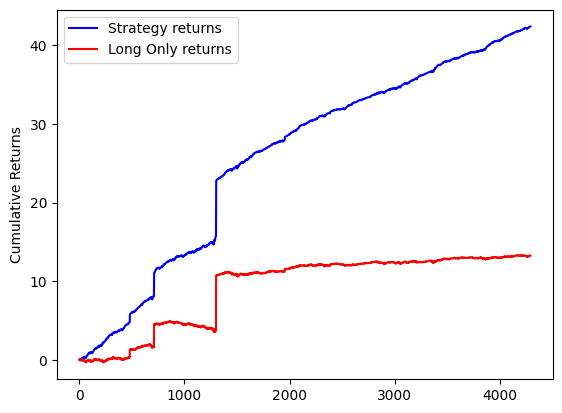

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Predict the next state at each time stamp using the Bayesian Transition Probability Matrix
def predict_next_state_max(cur_state, transition_prob):
    # Return the state with the maximum probability
    return transition_prob.loc[cur_state].idxmax()

df['state'] = list(zip(df['skewness_state'], df['volatility_state'], df['investment_strategy']))


df['predicted_next_state'] = df['state'].apply(lambda x: predict_next_state_max(x, posterior_probs_df))

print(df['predicted_next_state'])


# Designing investment strategy
df['action'] = 0  

long_condition = (df['predicted_next_state'].apply(lambda x: x[1] in [0,1, 2, 3, 4])) 

# Criteria for going short: Negative sentiment or Aggressive category
short_condition = (df['predicted_next_state'].apply(lambda x: x[1] in [-1, -2, -3, -4]))


df.loc[long_condition, 'action'] = 1

# Set 'action' to -1 for short positions
df.loc[short_condition, 'action'] = -1

# Calculate returns and total returns
df["returns"] = df["close"].pct_change()
df["total_returns"] = abs(df["returns"]) * df["action"]

# df.set_index("date", inplace=True)

# Display the value counts of trading actions
print(df["action"].value_counts())

# Plot cumulative returns
df["total_returns"].cumsum().plot(label="Strategy returns", color='blue')
df["returns"].cumsum().plot(color='red', label="Long Only returns")
plt.legend()
plt.ylabel("Cumulative Returns")
plt.show()


Only Considering Skewness


/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/2653774243.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = list(zip(df['skewness_state'], df['volatility_state'], df['investment_strategy']))
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/2653774243.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_next_state'] = df['state'].apply(lambda x: predict_next_state_max(x, posterior_probs_df))


2             (Negative, 3, Neutral)
3             (Negative, 0, Neutral)
4             (Negative, 4, Neutral)
5             (Negative, 0, Neutral)
6             (Negative, 0, Neutral)
7             (Negative, 3, Neutral)
8            (Negative, -4, Neutral)
9             (Negative, 0, Neutral)
10           (Negative, -4, Neutral)
11           (Negative, -4, Neutral)
12           (Negative, -4, Neutral)
13            (Negative, 0, Neutral)
14            (Negative, 0, Neutral)
15            (Negative, 0, Neutral)
16            (Negative, 3, Neutral)
17            (Negative, 4, Neutral)
18            (Negative, 4, Neutral)
19            (Negative, 0, Neutral)
20            (Negative, 1, Neutral)
21            (Positive, 0, Neutral)
22            (Positive, 0, Neutral)
23            (Positive, 0, Neutral)
24            (Positive, 0, Neutral)
25            (Positive, 0, Neutral)
26            (Positive, 0, Neutral)
27           (Positive, -4, Neutral)
28           (Positive, -4, Neutral)
2

/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/2653774243.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action'] = 0
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/2653774243.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = df["close"].pct_change()
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/2653774243.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

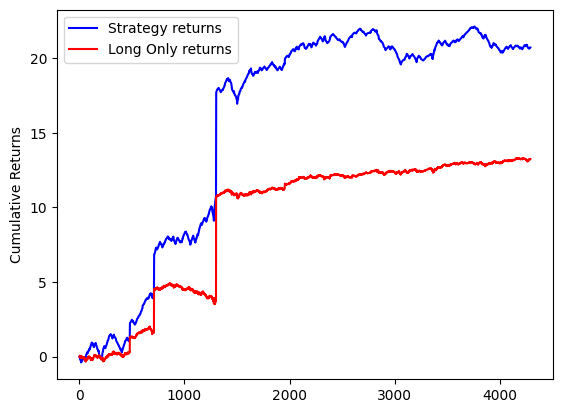

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Predict the next state at each time stamp using the Bayesian Transition Probability Matrix
def predict_next_state_max(cur_state, transition_prob):
    # Return the state with the maximum probability
    return transition_prob.loc[cur_state].idxmax()

df['state'] = list(zip(df['skewness_state'], df['volatility_state'], df['investment_strategy']))

df['predicted_next_state'] = df['state'].apply(lambda x: predict_next_state_max(x, posterior_probs_df))

print(df['predicted_next_state'])

# Designing investment strategy
df['action'] = 0  

long_condition = (df['predicted_next_state'].apply(lambda x: x[0]) == 'Positive') 

# Criteria for going short: Negative sentiment or Aggressive category
short_condition = (df['predicted_next_state'].apply(lambda x: x[0]) == 'Negative') 


df.loc[long_condition, 'action'] = 1
df.loc[short_condition, 'action'] = -1

# Calculate returns and total returns
df["returns"] = df["close"].pct_change()
df["total_returns"] = abs(df["returns"]) * df["action"]


# df.set_index("date", inplace=True)

print(df["action"].value_counts())

# Plot cumulative returns
df["total_returns"].cumsum().plot(label="Strategy returns", color='blue')
df["returns"].cumsum().plot(color='red', label="Long Only returns")
plt.legend()
plt.ylabel("Cumulative Returns")
plt.show()


Only Considering Volatility (Simple Transition Probability)

/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/469049193.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = list(zip(df['skewness_state'], df['volatility_state'], df['investment_strategy']))
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/469049193.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_next_state'] = df['state'].apply(lambda x: predict_next_state_max(x, transition_prob))


2             (Negative, 3, Neutral)
3             (Negative, 0, Neutral)
4             (Negative, 4, Neutral)
5             (Negative, 0, Neutral)
6             (Negative, 0, Neutral)
7             (Negative, 3, Neutral)
8            (Negative, -4, Neutral)
9             (Negative, 0, Neutral)
10           (Negative, -4, Neutral)
11           (Negative, -4, Neutral)
12           (Negative, -4, Neutral)
13            (Negative, 0, Neutral)
14            (Negative, 0, Neutral)
15            (Negative, 0, Neutral)
16            (Negative, 3, Neutral)
17            (Negative, 4, Neutral)
18            (Negative, 4, Neutral)
19            (Negative, 0, Neutral)
20            (Negative, 1, Neutral)
21            (Positive, 0, Neutral)
22            (Positive, 0, Neutral)
23            (Positive, 0, Neutral)
24            (Positive, 0, Neutral)
25            (Positive, 0, Neutral)
26            (Positive, 0, Neutral)
27           (Positive, -4, Neutral)
28           (Positive, -4, Neutral)
2

/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/469049193.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action'] = 0  # Initialize the 'action' column with zeros
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/469049193.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = df["close"].pct_change()
/var/folders/ws/jkc6jrvj6051_zm0nbgctb2m0000gn/T/ipykernel_35876/469049193.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

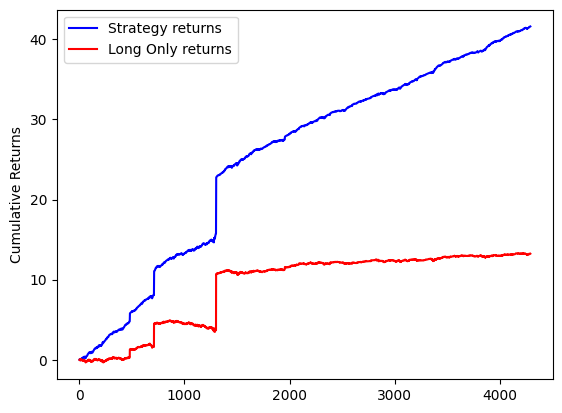

In [16]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Assuming df is your DataFrame with the Simple Transition Probability Matrix (posterior_probs_df) and the state column

# Predict the next state at each time stamp using the Bayesian Transition Probability Matrix
def predict_next_state_max(cur_state, transition_prob):
    # Return the state with the maximum probability
    return transition_prob.loc[cur_state].idxmax()

# Create a new column 'state' by combining the three columns
df['state'] = list(zip(df['skewness_state'], df['volatility_state'], df['investment_strategy']))

# Apply the prediction function to each row in the DataFrame
df['predicted_next_state'] = df['state'].apply(lambda x: predict_next_state_max(x, transition_prob))

print(df['predicted_next_state'])
# Assuming df is your DataFrame with the 'predicted_next_state' column

# Designing investment strategy
df['action'] = 0  # Initialize the 'action' column with zeros

long_condition = (df['predicted_next_state'].apply(lambda x: x[1] in [0,1,2,3,4])) 

# Criteria for going short: Negative sentiment or Aggressive category
short_condition = (df['predicted_next_state'].apply(lambda x: x[1] in [-2,-3,-1,-4]))

# Set 'action' to 1 for long positions
df.loc[long_condition, 'action'] = 1

# Set 'action' to -1 for short positions
df.loc[short_condition, 'action'] = -1


# Calculate returns and total returns
df["returns"] = df["close"].pct_change()
df["total_returns"] = abs(df["returns"]) * df["action"]

# # Set the index to the 'Date' column
# df.set_index("date", inplace=True)

# Display the value counts of trading actions
print(df["action"].value_counts())

# Plot cumulative returns
df["total_returns"].cumsum().plot(label="Strategy returns", color='blue')
df["returns"].cumsum().plot(color='red', label="Long Only returns")
plt.legend()
plt.ylabel("Cumulative Returns")
plt.show()


Test dataset[Only Considering Volatility (Bayesian Transition Probability)]

In [17]:

# Skewness
stock_data_with_skewness = skewness_states(test_data, window=20)

# Volatility
stock_data_with_skewness_and_volatility = volatility_states(stock_data_with_skewness, window=20, k=0.5)

# pd.set_option('display.max_rows', None)
# # Display the DataFrame with skewness information
# stock_data_with_skewness_and_volatility.head(40)

def classify_percentiles(series):
    low_threshold = series.quantile(0.2)
    medium_threshold = series.quantile(0.5)
    high_threshold = series.quantile(0.7)

    return pd.cut(series, bins=[float('-inf'), low_threshold, medium_threshold, high_threshold, float('inf')],
                  labels=['Very Low', 'Low', 'Medium', 'High'], include_lowest=True)


df_test = stock_data_with_skewness_and_volatility
df_test.head(40)

,datetime,close,open,volume,vwap,transactions,daily_returns,rolling_std,sign,skewness,skewness_state,cum_sum,volatility_state
3003,2018-10-11 13:00:00 EDT,26.805,27.0450,2500844.0,26.6111,12456,-0.005380,0.013650,-1.0,NaN,Negative,-0.005380,0
3004,2018-10-12 13:00:00 EDT,26.645,26.5650,2610460.0,26.6614,12559,-0.005969,0.013344,-1.0,NaN,Negative,-0.011349,-1
3005,2018-10-15 13:00:00 EDT,26.070,26.2650,2761938.0,26.1948,12494,-0.021580,0.013811,-1.0,NaN,Negative,-0.032929,-4
3006,2018-10-16 13:00:00 EDT,26.550,26.3950,2920638.0,26.5066,12062,0.018412,0.014806,1.0,NaN,Negative,0.018412,2
3007,2018-10-17 13:00:00 EDT,26.330,26.3700,2690746.0,26.3808,10678,-0.008286,0.014774,-1.0,NaN,Negative,-0.008286,-1
3008,2018-10-18 13:00:00 EDT,25.915,25.9800,2758084.0,25.8961,13788,-0.015761,0.013863,-1.0,NaN,Negative,-0.024048,-3
3009,2018-10-19 13:00:00 EDT,26.055,26.1650,2029894.0,26.1485,9890,0.005402,0.014137,1.0,NaN,Negative,0.005402,0
3010,2018-10-22 13:00:00 EDT,26.045,26.1500,1662702.0,26.1196,8257,-0.000384,0.013575,-1.0,NaN,Negative,-0.000384,0
3011,2018-10-23 13:00:00 EDT,26.320,26.1625,3917236.0,26.3697,18338,0.010559,0.014039,1.0,NaN,Negative,0.010559,1
3012,2018-10-24 13:00:00 EDT,26.800,26.4750,3884402.0,26.2256,16819,0.018237,0.014756,1.0,NaN,Negative,0.028796,3


In [18]:

df_test['price_level_state'] = classify_percentiles(df_test['close'])
df_test['volume_level_state'] = classify_percentiles(df_test['volume'])
df_test['transaction_level_state'] = classify_percentiles(df_test['transactions'])

def integrate_strategy(row):
    if row['price_level_state'] == 'Low' and row['volume_level_state'] == 'Low' and row['transaction_level_state'] == 'Low':
        return 'Conservative'
    elif row['price_level_state'] == 'High' and row['volume_level_state'] == 'High' and row['transaction_level_state'] == 'High':
        return 'Aggressive'
    else:
        return 'Neutral'

df_test['investment_strategy'] = df_test.apply(integrate_strategy, axis=1)

pd.set_option('display.max_rows', None)
# Display the DataFrame with skewness information
print(df_test.shape)

print(df_test['investment_strategy'].value_counts())


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def predict_next_state_max(cur_state, transition_prob):
    # Return the state with the maximum probability
    return transition_prob.loc[cur_state].idxmax()

# Create a new column 'state' by combining the three columns
df_test['state'] = list(zip(df_test['skewness_state'], df_test['volatility_state'], df_test['investment_strategy']))

# Apply the prediction function to each row in the DataFrame
df_test['predicted_next_state'] = df_test['state'].apply(lambda x: predict_next_state_max(x, posterior_probs_df))

print(df_test['predicted_next_state'])
df_test.head(50)


(1287, 17)
Neutral         1174
Conservative      60
Aggressive        53
Name: investment_strategy, dtype: int64
3003          (Negative, 0, Neutral)
3004          (Negative, 1, Neutral)
3005         (Negative, -4, Neutral)
3006          (Negative, 3, Neutral)
3007          (Negative, 1, Neutral)
3008         (Negative, -4, Neutral)
3009          (Negative, 0, Neutral)
3010          (Negative, 0, Neutral)
3011          (Negative, 0, Neutral)
3012          (Negative, 4, Neutral)
3013         (Negative, -4, Neutral)
3014         (Negative, -4, Neutral)
3015          (Negative, 0, Neutral)
3016          (Negative, 4, Neutral)
3017          (Negative, 0, Neutral)
3018          (Negative, 3, Neutral)
3019          (Negative, 0, Neutral)
3020          (Negative, 0, Neutral)
3021          (Negative, 0, Neutral)
3022         (Negative, -4, Neutral)
3023          (Negative, 0, Neutral)
3024          (Negative, 4, Neutral)
3025         (Negative, -4, Neutral)
3026          (Negative, 0, Neutral

,datetime,close,open,volume,vwap,transactions,daily_returns,rolling_std,sign,skewness,skewness_state,cum_sum,volatility_state,price_level_state,volume_level_state,transaction_level_state,investment_strategy,state,predicted_next_state
3003,2018-10-11 13:00:00 EDT,26.8050,27.0450,2500844.0,26.6111,12456,-0.005380,0.013650,-1.0,NaN,Negative,-0.005380,0,Very Low,Medium,Low,Neutral,"(Negative, 0, Neutral)","(Negative, 0, Neutral)"
3004,2018-10-12 13:00:00 EDT,26.6450,26.5650,2610460.0,26.6614,12559,-0.005969,0.013344,-1.0,NaN,Negative,-0.011349,-1,Very Low,Medium,Low,Neutral,"(Negative, -1, Neutral)","(Negative, 1, Neutral)"
3005,2018-10-15 13:00:00 EDT,26.0700,26.2650,2761938.0,26.1948,12494,-0.021580,0.013811,-1.0,NaN,Negative,-0.032929,-4,Very Low,Medium,Low,Neutral,"(Negative, -4, Neutral)","(Negative, -4, Neutral)"
3006,2018-10-16 13:00:00 EDT,26.5500,26.3950,2920638.0,26.5066,12062,0.018412,0.014806,1.0,NaN,Negative,0.018412,2,Very Low,High,Low,Neutral,"(Negative, 2, Neutral)","(Negative, 3, Neutral)"
3007,2018-10-17 13:00:00 EDT,26.3300,26.3700,2690746.0,26.3808,10678,-0.008286,0.014774,-1.0,NaN,Negative,-0.008286,-1,Very Low,Medium,Very Low,Neutral,"(Negative, -1, Neutral)","(Negative, 1, Neutral)"
3008,2018-10-18 13:00:00 EDT,25.9150,25.9800,2758084.0,25.8961,13788,-0.015761,0.013863,-1.0,NaN,Negative,-0.024048,-3,Very Low,Medium,Low,Neutral,"(Negative, -3, Neutral)","(Negative, -4, Neutral)"
3009,2018-10-19 13:00:00 EDT,26.0550,26.1650,2029894.0,26.1485,9890,0.005402,0.014137,1.0,NaN,Negative,0.005402,0,Very Low,Low,Very Low,Neutral,"(Negative, 0, Neutral)","(Negative, 0, Neutral)"
3010,2018-10-22 13:00:00 EDT,26.0450,26.1500,1662702.0,26.1196,8257,-0.000384,0.013575,-1.0,NaN,Negative,-0.000384,0,Very Low,Low,Very Low,Neutral,"(Negative, 0, Neutral)","(Negative, 0, Neutral)"
3011,2018-10-23 13:00:00 EDT,26.3200,26.1625,3917236.0,26.3697,18338,0.010559,0.014039,1.0,NaN,Negative,0.010559,1,Very Low,High,Medium,Neutral,"(Negative, 1, Neutral)","(Negative, 0, Neutral)"
3012,2018-10-24 13:00:00 EDT,26.8000,26.4750,3884402.0,26.2256,16819,0.018237,0.014756,1.0,NaN,Negative,0.028796,3,Very Low,High,Medium,Neutral,"(Negative, 3, Neutral)","(Negative, 4, Neutral)"


 1    700
-1    587
Name: action, dtype: int64


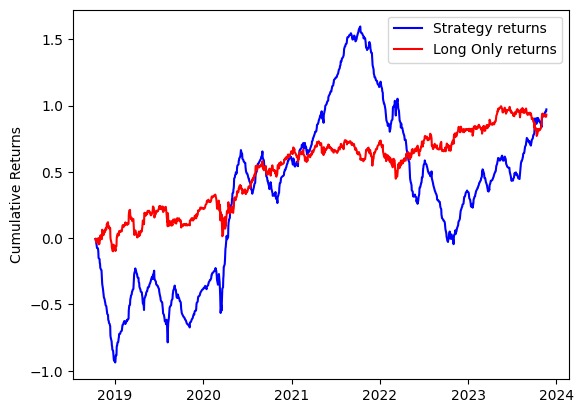

In [23]:
# Designing investment strategy
df_test['action'] = 0  

long_condition = (df_test['predicted_next_state'].apply(lambda x: x[0]) == 'Positive')

short_condition = (df_test['predicted_next_state'].apply(lambda x: x[0]) == 'Negative')


# Set 'action' to 1 for long positions
df_test.loc[long_condition, 'action'] = 1

# Set 'action' to -1 for short positions
df_test.loc[short_condition, 'action'] = -1

# Calculate returns and total returns
df_test["returns"] = df_test["close"].pct_change()
df_test["total_returns"] = abs(df_test["returns"]) * df_test["action"]


print(df_test["action"].value_counts())
# df_test['datetime'] = df_test['datetime'].apply(lambda x: x[0:10])
# df_test['datetime'] = pd.to_datetime(df_test['datetime'], format="%Y-%m-%d")

plt.plot(df_test["datetime"], df_test["total_returns"].cumsum(),label="Strategy returns", color='blue')
plt.plot(df_test["datetime"], df_test["returns"].cumsum(),color='red', label="Long Only returns")
# df_test["total_returns"].cumsum().plot(label="Strategy returns", color='blue')
# df_test["returns"].cumsum().plot(color='red', label="Long Only returns")
plt.legend()
plt.ylabel("Cumulative Returns")
plt.show()

In [22]:
df_test

,datetime,close,open,volume,vwap,transactions,daily_returns,rolling_std,sign,skewness,...,volatility_state,price_level_state,volume_level_state,transaction_level_state,investment_strategy,state,predicted_next_state,action,returns,total_returns
3003,2018-10-11,26.8050,27.0450,2500844.0,26.6111,12456,-0.005380,0.013650,-1.0,NaN,...,0,Very Low,Medium,Low,Neutral,"(Negative, 0, Neutral)","(Negative, 0, Neutral)",-1,NaN,NaN
3004,2018-10-12,26.6450,26.5650,2610460.0,26.6614,12559,-0.005969,0.013344,-1.0,NaN,...,-1,Very Low,Medium,Low,Neutral,"(Negative, -1, Neutral)","(Negative, 1, Neutral)",-1,-0.005969,-0.005969
3005,2018-10-15,26.0700,26.2650,2761938.0,26.1948,12494,-0.021580,0.013811,-1.0,NaN,...,-4,Very Low,Medium,Low,Neutral,"(Negative, -4, Neutral)","(Negative, -4, Neutral)",-1,-0.021580,-0.021580
3006,2018-10-16,26.5500,26.3950,2920638.0,26.5066,12062,0.018412,0.014806,1.0,NaN,...,2,Very Low,High,Low,Neutral,"(Negative, 2, Neutral)","(Negative, 3, Neutral)",-1,0.018412,-0.018412
3007,2018-10-17,26.3300,26.3700,2690746.0,26.3808,10678,-0.008286,0.014774,-1.0,NaN,...,-1,Very Low,Medium,Very Low,Neutral,"(Negative, -1, Neutral)","(Negative, 1, Neutral)",-1,-0.008286,-0.008286
3008,2018-10-18,25.9150,25.9800,2758084.0,25.8961,13788,-0.015761,0.013863,-1.0,NaN,...,-3,Very Low,Medium,Low,Neutral,"(Negative, -3, Neutral)","(Negative, -4, Neutral)",-1,-0.015761,-0.015761
3009,2018-10-19,26.0550,26.1650,2029894.0,26.1485,9890,0.005402,0.014137,1.0,NaN,...,0,Very Low,Low,Very Low,Neutral,"(Negative, 0, Neutral)","(Negative, 0, Neutral)",-1,0.005402,-0.005402
3010,2018-10-22,26.0450,26.1500,1662702.0,26.1196,8257,-0.000384,0.013575,-1.0,NaN,...,0,Very Low,Low,Very Low,Neutral,"(Negative, 0, Neutral)","(Negative, 0, Neutral)",-1,-0.000384,-0.000384
3011,2018-10-23,26.3200,26.1625,3917236.0,26.3697,18338,0.010559,0.014039,1.0,NaN,...,1,Very Low,High,Medium,Neutral,"(Negative, 1, Neutral)","(Negative, 0, Neutral)",-1,0.010559,-0.010559
3012,2018-10-24,26.8000,26.4750,3884402.0,26.2256,16819,0.018237,0.014756,1.0,NaN,...,3,Very Low,High,Medium,Neutral,"(Negative, 3, Neutral)","(Negative, 4, Neutral)",-1,0.018237,-0.018237


Transition probability changing